<a href="https://colab.research.google.com/github/Patric/fkd-gs/blob/master/notebooks/FakeNewsDetectionGraphSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection using graph solutions

This notebook is a walkthrough feature selection process and machine learning effects of Fake news detection using graph solution Master's Thesis.

First launch Dataset loading with 15 hidden cells,
then feature selection and testing classifiers can be launched independetly - just needs setting prerequisites section

# Code formatting
Use !black command once to format the code, then use F5 and then save. Uncomment when needed

In [1]:
# ! pip install black[jupyter]

In [2]:
# !black /content/drive/MyDrive/ColabNotebooks/FakeNewsDetectionGraphSolutions.ipynb

# Dataset loading

## Mount google drive with processed features and define dataset paths

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libs for operating on datasets

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from enum import Enum

### Set datasets paths variables and map column names to features

Warning!!! These are Colab based paths. As for now data should be saved to your google drive from https://drive.google.com/drive/folders/1HOEIyiiFBALoqrHN5Jh8RczkvMIgUVyH?usp=sharing
 Paths should be adjusted accordingly

In [4]:
# variable should be adjusted according to your google drive TODO: figure out how to bond datasets more simply
features_directory_path = "/content/drive/MyDrive/FakeNewsDetectonColabNotebooks/resources/features"

politifact_more_than_1_relation_path = (
    f"{features_directory_path}/politifact_more_than_1_relation/"
)
politifact_all_path = f"{features_directory_path}/politifact_all/"
gossipcop_path = f"{features_directory_path}/gossipcop/"

e13_followers_path = f"{features_directory_path}/MIB/E13/"
fsf_followers_path = f"{features_directory_path}/MIB/FSF/"
int_followers_path = f"{features_directory_path}/MIB/INT/"
twt_followers_path = f"{features_directory_path}/MIB/TWT/"
tfp_followers_path = f"{features_directory_path}/MIB/TFP/"

In [5]:
features_files_names = [
    "eigenvector_to_label.csv",
    "harmonic_closeness_to_label.csv",
    "hits_to_label.csv",
    "betweenness_to_label.csv",
    "closeness_to_label.csv",
    "page_rank_to_label.csv",
    "article_rank_to_label.csv",
    "degree_to_label.csv",
]

class FeatureColumnName(Enum):
  EIGENVECTOR = 'eigenvector_score'
  HARMONIC_CLOSENESS = 'harmonic_closeness_centrality'
  CLOSENESS = 'closeness_score'
  HITS_HUB = 'hits_hub'
  HITS_AUTH = 'hits_auth'
  BETWEENNESS = 'betweenness_score'
  PAGE_RANK = 'page_rank_score'
  ARTICLE_RANK = 'article_rank_score'
  OUT_DEGREE = 'outDegree'
  IN_DEGREE = 'inDegree'
  DEGREE = 'degree'

## Define util functions

In [6]:
def get_data_frame(*paths):
    paths = list(sum(paths, []))
    dfs = list(map(lambda path: pd.read_csv(path), paths))
    df = pd.concat(dfs, join="outer", axis=1)
    df = df.loc[:, ~df.columns.duplicated()].copy()
    return df


def get_feature_full_path(data_set_path, feature_data):
    return f"{data_set_path}{feature_data}"


def get_features_paths(data_set_path, features_files):
    return list(
        map(
            lambda feature_file: get_feature_full_path(data_set_path, feature_file),
            features_files,
        )
    )

In [7]:
# split into dependend and independent variables
def split_into_X_y(data_frame, dependent_variables_list, independend_variable):
  X = data_frame[dependent_variables_list]
  y = data_frame[independend_variable]

  return X, y

## Convert datasets to Pandas DataFrames

In [8]:
paths_array = [e13_followers_path, fsf_followers_path, int_followers_path, twt_followers_path, tfp_followers_path]
mib_combined = list(map(lambda dataset_path: get_data_frame(get_features_paths(dataset_path, features_files_names)), paths_array))
dfs_mib_combined = pd.concat(mib_combined)

In [9]:
df_politifact = get_data_frame(get_features_paths(politifact_all_path, features_files_names))
df_politifact_more_than_1_relation = get_data_frame(get_features_paths(politifact_more_than_1_relation_path, features_files_names))

df_gossipcop = get_data_frame(get_features_paths(gossipcop_path, features_files_names))

df_fake_news_net_skeleton_combined = pd.concat([df_politifact, df_gossipcop])

In [10]:
datasets = {
    'politifact': df_politifact,
    'gossipcop': df_gossipcop,
    # fake_news_skeleton_combined = politifact + gossipcop
    'fake_news_skeleton_combined': df_fake_news_net_skeleton_combined,
    'mib_combined': dfs_mib_combined,
    'mib_combined_at_least_1_degree': dfs_mib_combined.copy().query('degree >= 1')
}

# Feature selection


## Set prerequisites

### Import libs for feature selection

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from IPython.display import display
import seaborn as sns

### Define feature selection **functions**

In [16]:
def select_features_chi2(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=chi2, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    row = []
    row.append(fs.scores_[i])
    if hasattr(fs, 'pvalues_'):
      row.append(fs.pvalues_[i])
      results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['Chi2 scores', 'Chi2 pvalues'], index=feature_names)

In [17]:
def select_features_f(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=f_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['F-test scores', 'F-test pvalues'], index=feature_names)

In [18]:
def select_features_mutual_info(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Mutual info scores'], index=feature_names)

In [19]:
def select_features_r(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=r_regression, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Pearson scores'], index=feature_names)

In [20]:
def tree_classifier(X, y):
  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  feature_names = []
  scores = []
  for i in range(len(clf.feature_importances_)):
    feature_names.append(clf.feature_names_in_[i])
    scores.append([clf.feature_importances_[i]])

  return pd.DataFrame(scores, columns=['Tree classifier importances'], index=feature_names)

In [21]:
def plot_pearson_corr_matrix(data_frame, name):
  corr = data_frame.corr(method='pearson')
  plt.figure(figsize=(20, 10))
  # Increase the size of the 
  heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
  heatmap.set_title(f'{name} pearson correlation Heatmap', fontdict={'fontsize':12}, pad=12)
  plt.show()

In [22]:
def test_linear_regression_model(X_train, y_train, X_test, y_test):
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  plt.scatter(y_test,y_pred)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
  plt.show()

In [23]:
def test_feature_dependency_for_dataset(df, df_name='Data frame'):
  features_included = [
          FeatureColumnName.EIGENVECTOR.value,
          FeatureColumnName.HARMONIC_CLOSENESS.value,
          FeatureColumnName.HITS_HUB.value,
          FeatureColumnName.HITS_AUTH.value,
          FeatureColumnName.BETWEENNESS.value,
          FeatureColumnName.CLOSENESS.value,
          FeatureColumnName.PAGE_RANK.value,
          FeatureColumnName.ARTICLE_RANK.value,
          FeatureColumnName.OUT_DEGREE.value,
          FeatureColumnName.IN_DEGREE.value,
          FeatureColumnName.DEGREE.value
          ]
  
  label_column_name = 'user.label'
  X, y = split_into_X_y(df, features_included, label_column_name)

  plot_pearson_corr_matrix(df, df_name)
  df_mi = select_features_mutual_info(X, y)
  df_f = select_features_f(X, y)
  df_chi2 = select_features_chi2(X, y)
  df_r = select_features_r(X, y)
  df_t =  tree_classifier(X, y)
  df_output = pd.concat([df_mi, df_f, df_chi2, df_r, df_t], axis=1)

  display(df_output)

  print(f'Linear regression of features: {features_included}')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  test_linear_regression_model(X_train, y_train, X_test, y_test)

## Test feature dependency

### Select gossipcop features
In this case most significant features turned out to be page rank score and article score - page rank chosen as they were both correlated

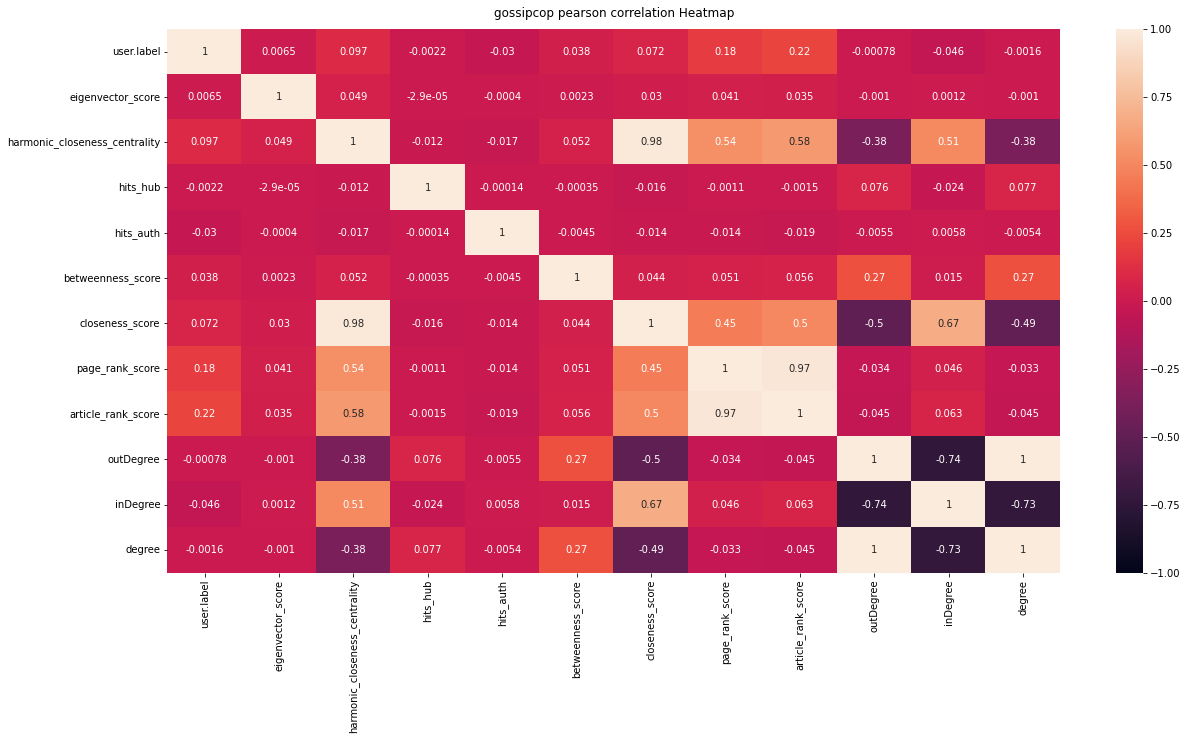

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.010970,13.190209,2.814602e-04,2.558772,1.096838e-01,0.006478,0.001706
harmonic_closeness_centrality,0.012179,2976.465915,0.000000e+00,0.000708,9.787734e-01,0.096863,0.025769
hits_hub,0.000000,1.512292,2.187905e-01,0.844316,3.581653e-01,-0.002194,0.000099
hits_auth,0.011886,282.384268,2.419682e-63,11.521324,6.880238e-04,-0.029963,0.014820
betweenness_score,0.010325,445.079755,9.944722e-99,12701.545686,0.000000e+00,0.037607,0.018046
closeness_score,0.010166,1637.603255,0.000000e+00,0.000216,9.882658e-01,0.072000,0.024806
page_rank_score,0.207444,10651.679683,0.000000e+00,69.851927,6.392761e-17,0.181062,0.407093
article_rank_score,0.208309,16389.056131,0.000000e+00,23.627514,1.169040e-06,0.222635,0.455512
outDegree,0.013279,0.191326,6.618158e-01,11.358420,7.510667e-04,-0.000780,0.026434
inDegree,0.041570,654.636317,3.084001e-144,11.358420,7.510667e-04,-0.045594,0.002499


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 9.18


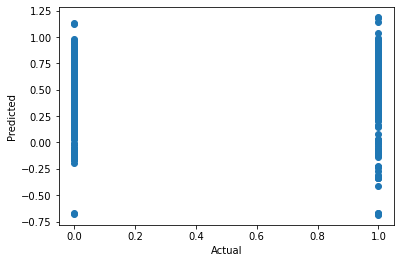

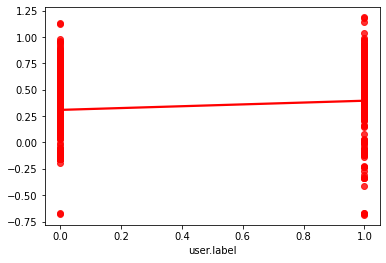

In [22]:
name = 'gossipcop'
test_feature_dependency_for_dataset(datasets[name], name)

### Select politifact features
Most significat features chosen: page rank based on correlation and betweenness based on chi2 test

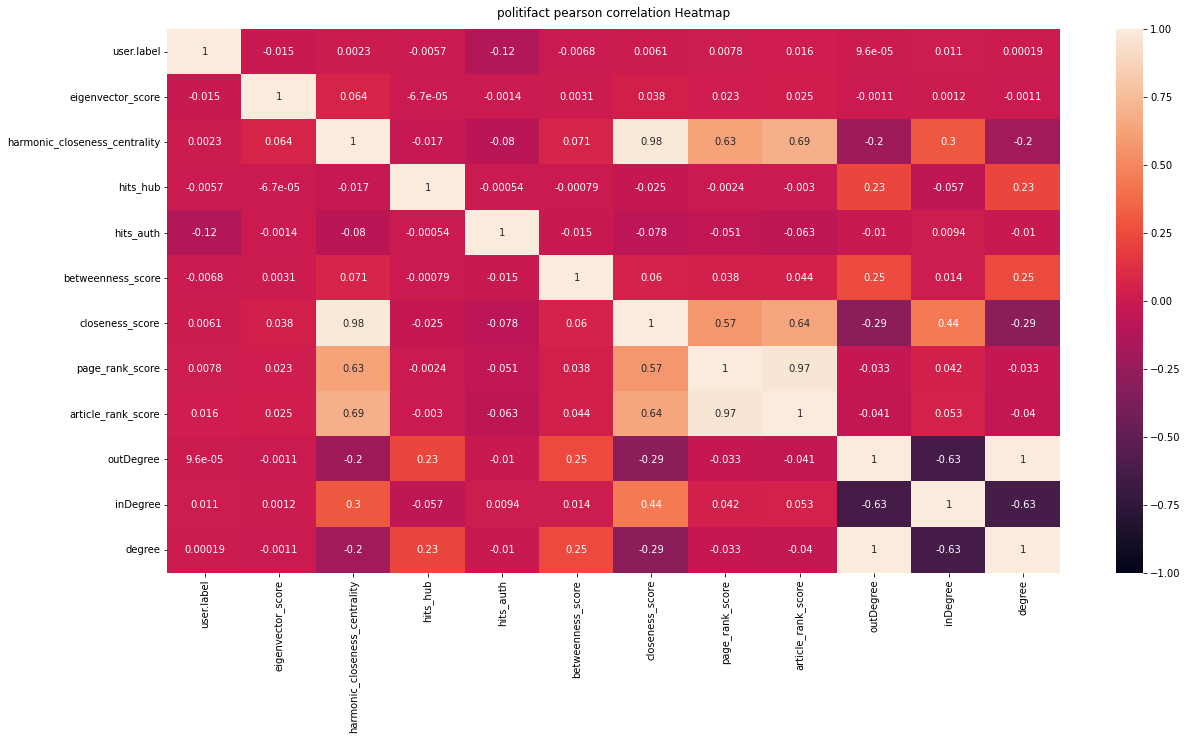

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.004045,8.666516,3.242917e-03,3.209727e+00,7.320168e-02,-0.014528,0.001265
harmonic_closeness_centrality,0.000000,0.210942,6.460327e-01,5.501489e-07,9.994082e-01,0.002267,0.006529
hits_hub,0.000000,1.314924,2.515117e-01,1.295041e+00,2.551211e-01,-0.005659,0.000019
hits_auth,0.024070,607.284610,4.058898e-133,2.747167e+01,1.594124e-07,-0.120737,0.027700
betweenness_score,0.000696,1.872635,1.711811e-01,7.470021e+01,5.479018e-18,-0.006754,0.013404
closeness_score,0.001181,1.531802,2.158493e-01,1.713813e-06,9.989555e-01,0.006108,0.005992
page_rank_score,0.561567,2.526979,1.119220e-01,3.734837e-02,8.467575e-01,0.007845,0.457668
article_rank_score,0.563712,10.646905,1.103453e-03,3.396648e-02,8.537781e-01,0.016102,0.469880
outDegree,0.000439,0.000380,9.844428e-01,3.599582e-02,8.495241e-01,0.000096,0.008576
inDegree,0.004582,4.706591,3.005289e-02,3.599582e-02,8.495241e-01,0.010707,0.000052


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is -19925343330752.84


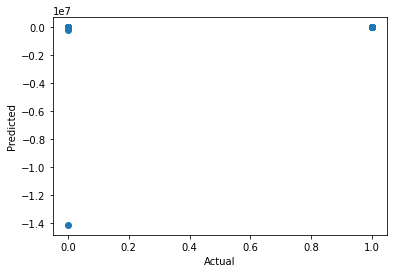

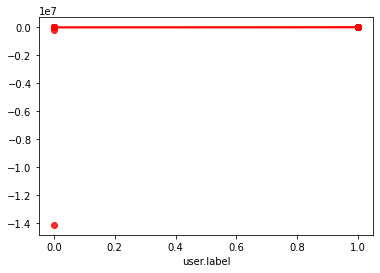

In [23]:
name = 'politifact'
test_feature_dependency_for_dataset(datasets[name], name)

### Select gossipcop + politifact features
Na podstawei tree classifier wybrany page rank, 

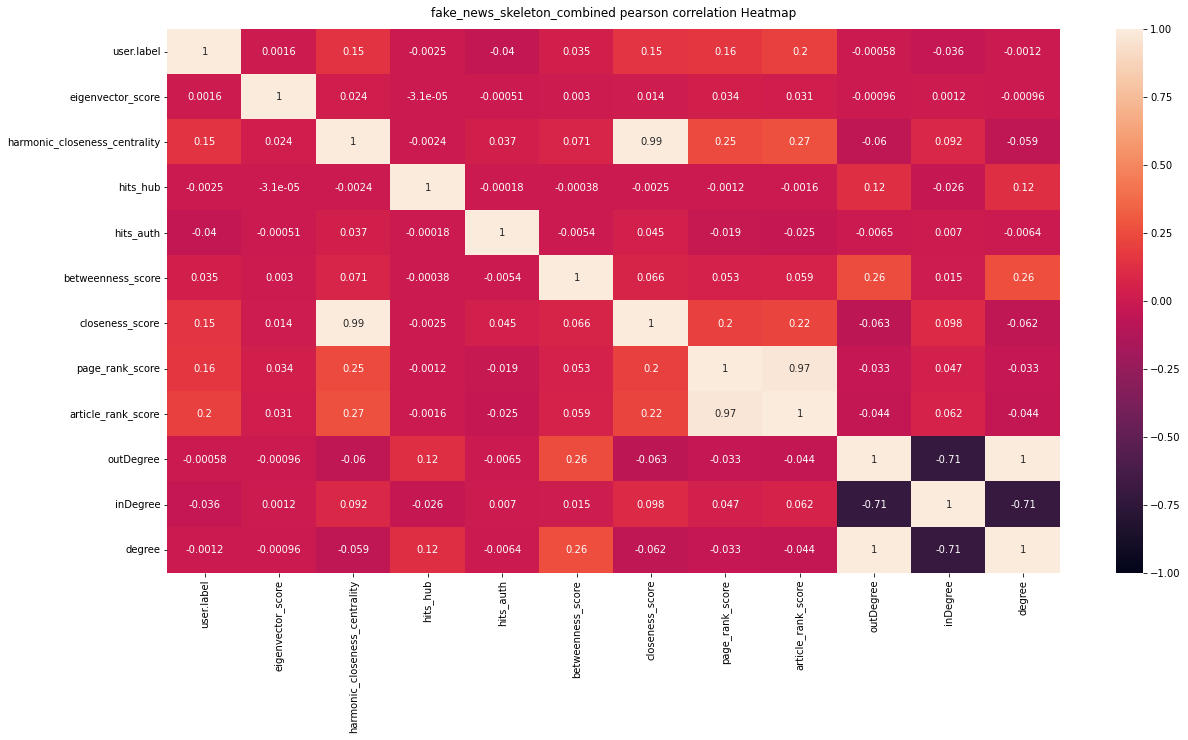

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.020033,0.929291,3.350480e-01,0.236638,6.266447e-01,0.001617,0.002146
harmonic_closeness_centrality,0.020673,7925.473775,0.000000e+00,0.101120,7.504897e-01,0.147712,0.040607
hits_hub,0.000701,2.147520,1.428013e-01,1.530386,2.160545e-01,-0.002458,0.000175
hits_auth,0.011933,583.670741,7.585179e-129,25.271232,4.980823e-07,-0.040497,0.016297
betweenness_score,0.008512,438.670251,2.414752e-97,13913.118608,0.000000e+00,0.035115,0.016094
closeness_score,0.019005,8073.976188,0.000000e+00,0.085863,7.695036e-01,0.149059,0.049357
page_rank_score,0.226409,9778.541494,0.000000e+00,74.900230,4.951123e-18,0.163657,0.402021
article_rank_score,0.259490,14958.179976,0.000000e+00,25.025981,5.656297e-07,0.200992,0.432062
outDegree,0.010259,0.120962,7.279933e-01,7.678823,5.587259e-03,-0.000583,0.019589
inDegree,0.046198,472.832148,9.078643e-105,7.678823,5.587259e-03,-0.036455,0.002302


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 8.03


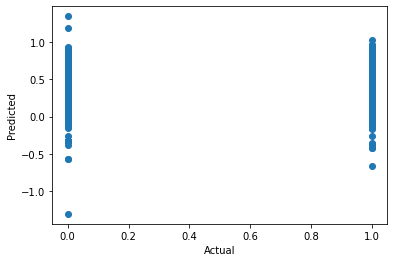

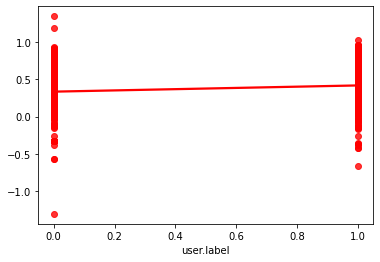

In [24]:
# politifact + gossipcop
name = 'fake_news_skeleton_combined'
test_feature_dependency_for_dataset(datasets[name], name)

### Select MIB combined user followers network features without users with only 1 degree

Harmonic closeness chosen as the only important feature based on correlation and tree classifier and eigenvector based on mutual information

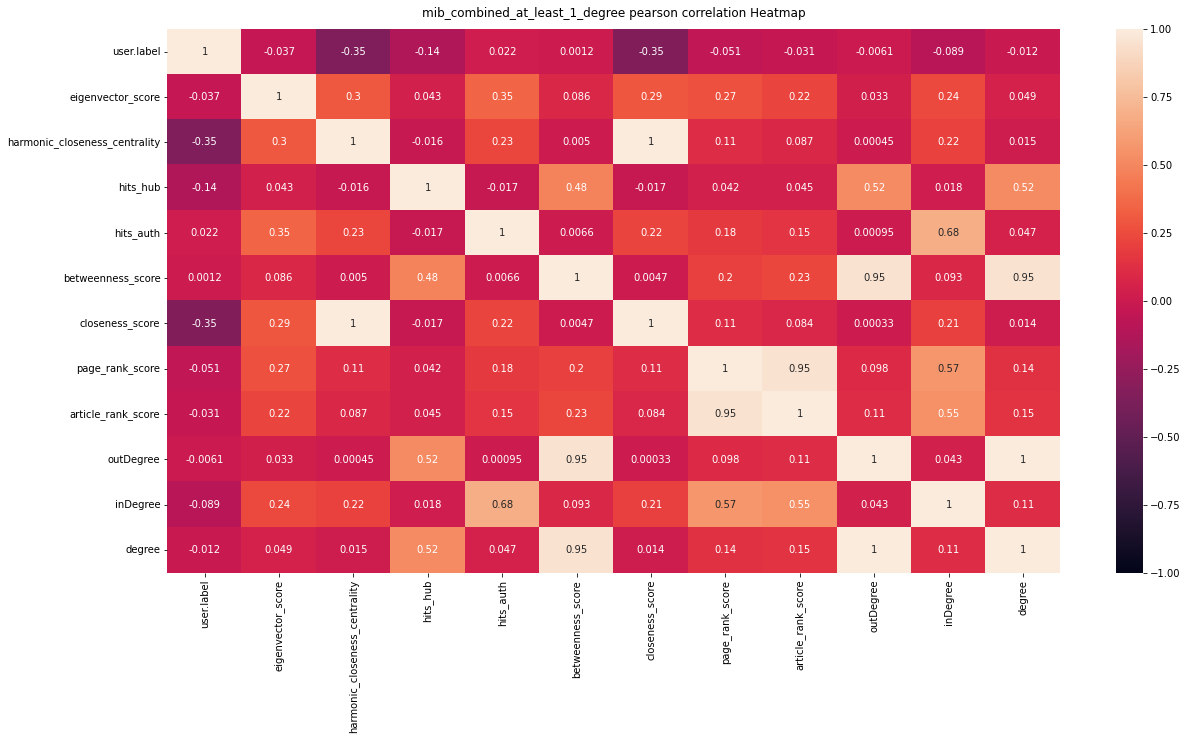

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.245022,1950.343996,0.000000e+00,9.941940e+00,1.615552e-03,-0.037398,0.007436
harmonic_closeness_centrality,0.270760,196599.695939,0.000000e+00,8.538933e+03,0.000000e+00,-0.351733,0.254959
hits_hub,0.190438,26842.826627,0.000000e+00,9.812976e+02,2.086998e-215,-0.137520,0.272494
hits_auth,0.248098,693.709356,7.608020e-153,3.032054e+00,8.163462e-02,0.022314,0.035973
betweenness_score,0.002211,2.082171,1.490284e-01,4.205253e+09,0.000000e+00,0.001223,0.000049
closeness_score,0.270506,190243.420743,0.000000e+00,7.738225e+03,0.000000e+00,-0.346694,0.379538
page_rank_score,0.262955,3580.209103,0.000000e+00,2.298690e+04,0.000000e+00,-0.050640,0.001181
article_rank_score,0.259719,1308.762711,1.917066e-286,7.084671e+02,4.310120e-156,-0.030643,0.001168
outDegree,0.114502,51.638882,6.674050e-13,3.397592e+06,0.000000e+00,-0.006089,0.019136
inDegree,0.177685,11221.403580,0.000000e+00,3.397592e+06,0.000000e+00,-0.089409,0.019170


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 25.11


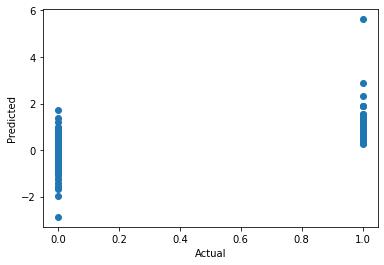

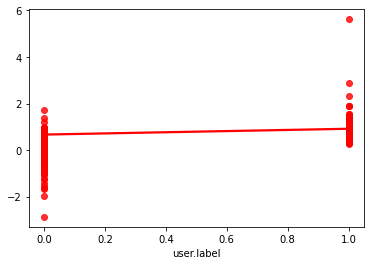

In [31]:
name = 'mib_combined_at_least_1_degree'
test_feature_dependency_for_dataset(datasets[name], name)

### Test all at once

In [26]:
# for dataset_name in datasets:
#   print(f'Testing feature dependency for: {dataset_name}')
#   test_feature_dependency_for_dataset(datasets[dataset_name], dataset_name)

# Classifiers testing

## Set prerequisites

### Import libs for classifiers *testing*

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold

### Define test classifiers functions

In [34]:
def test_classfiers(classifiers, X_train, X_test, y_train, y_test):
  log_cols = ["Classifier", "Accuracy", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("=" * 30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc * 100, ll]], columns=log_cols)
    log = log.append(log_entry)

  print("=" * 30)

## Politifact

### Test all classifiers and all features for Politifact

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('politifact'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

### Test best features and classifiers for Politifact

In [35]:
features_included = [
        'betweenness_score',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('politifact'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3)
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
Accuracy: 78.4279%
Log Loss: 0.8076619227259915
RandomForestClassifier
****Results****
Accuracy: 78.2224%
Log Loss: 0.47054210955251147
GradientBoostingClassifier
****Results****
Accuracy: 71.4877%
Log Loss: 0.564088940958417
GaussianNB
****Results****
Accuracy: 64.9077%
Log Loss: 0.8175612153883173
KNeighborsClassifier
****Results****
Accuracy: 72.3995%
Log Loss: 2.7770193074269947


## Gossipcop

### Test all classifiers and all features for Gossipcop

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('gossipcop'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

### Test best classifiers and best features for Gossipcop

In [ ]:
features_included = [
        'page_rank_score',
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('gossipcop'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),

]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

## Gossipcop + Politifact

### Test all classifiers and all features for Gossipcop + Politifact

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('fake_news_skeleton_combined'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

### Test best classifiers and best features for Gossipcop + Politifact


In [ ]:
features_included = [
        'page_rank_score',
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('fake_news_skeleton_combined'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB(),
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

## Test classifiers for MIB combined network of followers

### Test best classifiers for MIB combined and best features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'page_rank_score',
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('mib_combined_at_least_1_degree'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  GradientBoostingClassifier(),
  GaussianNB()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

### Test all classifiers for MIB combined and all features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets('mib_combined_at_least_1_degree'), features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)